In [1]:
# Import libraries
import pickle
import matplotlib.pyplot as plt

import econml
import dowhy
from dowhy import CausalModel

# Load Data
df = pickle.load( open( "df_causal_inference.p", "rb" ) )

In [2]:
df

,age,hasGraduateDegree,greaterThan50k
0,39,False,False
1,50,False,False
2,38,False,False
3,53,False,False
5,37,True,False
...,...,...,...
32556,27,False,False
32557,40,False,True
32558,58,False,False
32559,22,False,False


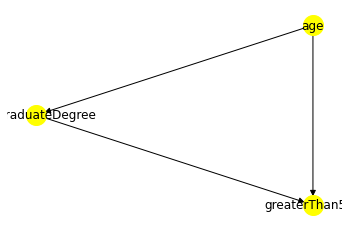

In [3]:
# Define causal model
model=CausalModel(data = df, treatment= "hasGraduateDegree", outcome= "greaterThan50k", common_causes="age")

# View model
model.view_model() 
# from IPython.display import Image, display 
# display(Image(filename="causal_model.png"))

In [4]:
# estimand: a recipe that gives us our desired causal effect
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                           
────────────────────(Expectation(greaterThan50k|age))
d[hasGraduateDegree]                                 
Estimand assumption 1, Unconfoundedness: If U→{hasGraduateDegree} and U→greaterThan50k then P(greaterThan50k|hasGraduateDegree,age,U) = P(greaterThan50k|hasGraduateDegree,age)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [5]:
# Compute causal effect using metalearner
identified_estimand_experiment = model.identify_effect(proceed_when_unidentifiable=True)

from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model.estimate_effect(
    identified_estimand_experiment, 
    method_name="backdoor.econml.metalearners.TLearner",
    confidence_intervals=False,
    method_params={
     "init_params":{'models': RandomForestRegressor()},
     "fit_params":{}
    })
# This can be interpreted as, having a graduate degree increases your probability of making more than $50k annually by 20%.
print(metalearner_estimate)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                           
────────────────────(Expectation(greaterThan50k|age))
d[hasGraduateDegree]                                 
Estimand assumption 1, Unconfoundedness: If U→{hasGraduateDegree} and U→greaterThan50k then P(greaterThan50k|hasGraduateDegree,age,U) = P(greaterThan50k|hasGraduateDegree,age)

## Realized estimand
b: greaterThan50k~hasGraduateDegree+age
Target units: ate

## Estimate
Mean value: 0.20510836933500362
Effect estimates: [ 0.29499142  0.20756705  0.36232627 ...  0.18047487 -0.0138065
  0.20170418]



(array([  74.,  123., 2417., 5232., 3178., 8203., 6384., 3087.,  435.,
          37.]),
 array([-0.29565221, -0.19964987, -0.10364754, -0.00764521,  0.08835713,
         0.18435946,  0.2803618 ,  0.37636413,  0.47236647,  0.5683688 ,
         0.66437113]),
 <BarContainer object of 10 artists>)

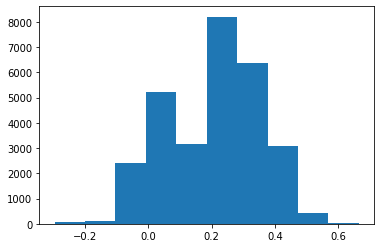

In [6]:
# Print histogram of causal effects
plt.hist(metalearner_estimate.cate_estimates)